In [49]:
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [50]:
df = pd.read_csv('traffic_accidents.csv')
df = df.dropna()
df = df.drop_duplicates()
print(df.shape)
print(df.columns.tolist())

(209275, 24)
['crash_date', 'traffic_control_device', 'weather_condition', 'lighting_condition', 'first_crash_type', 'trafficway_type', 'alignment', 'roadway_surface_cond', 'road_defect', 'crash_type', 'intersection_related_i', 'damage', 'prim_contributory_cause', 'num_units', 'most_severe_injury', 'injuries_total', 'injuries_fatal', 'injuries_incapacitating', 'injuries_non_incapacitating', 'injuries_reported_not_evident', 'injuries_no_indication', 'crash_hour', 'crash_day_of_week', 'crash_month']


In [51]:
sev = {'NO INDICATION OF INJURY':0,'NONINCAPACITATING INJURY':1,'INCAPACITATING INJURY':2,'FATAL':3}
df['severity'] = df['most_severe_injury'].map(sev)
df = df.dropna(subset=['severity'])
df['severity'] = df['severity'].astype(int)
print(df['severity'].value_counts().sort_index())

severity
0    154767
1     31521
2      6563
3       351
Name: count, dtype: int64


In [52]:
df['crash_date'] = pd.to_datetime(df['crash_date'])
df['Hour'] = df['crash_date'].dt.hour
df['Day_of_Week'] = df['crash_date'].dt.dayofweek + 1
df['Month'] = df['crash_date'].dt.month
df['Year'] = df['crash_date'].dt.year
df['Is_Weekend'] = (df['Day_of_Week'].isin([6,7])).astype(int)
df['Is_Rush_Hour'] = (df['Hour'].isin([7,8,9,16,17,18])).astype(int)
df['Season'] = df['Month'].apply(lambda x: 1 if x in [12,1,2] else (2 if x in [3,4,5] else (3 if x in [6,7,8] else 4)))

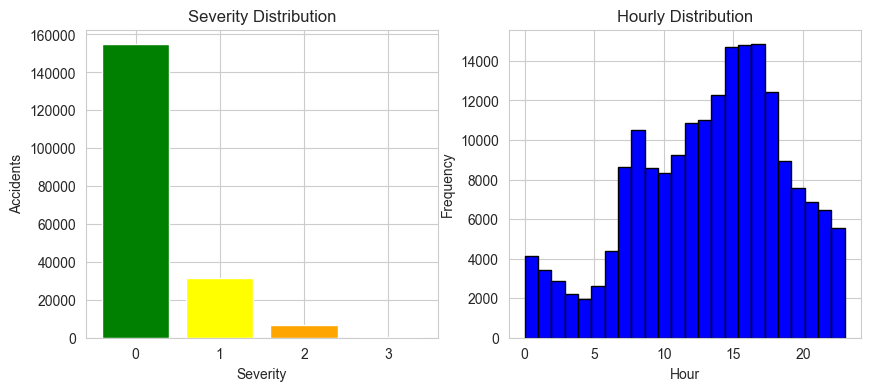

In [53]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.bar([0,1,2,3], df['severity'].value_counts().sort_index(), color=['green','yellow','orange','red'])
plt.title('Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Accidents')
plt.subplot(1,2,2)
plt.hist(df['Hour'], bins=24, color='blue', edgecolor='black')
plt.title('Hourly Distribution')
plt.xlabel('Hour')
plt.ylabel('Frequency')
plt.show()

In [54]:
cols = ['weather_condition','lighting_condition','traffic_control_device','first_crash_type',
        'trafficway_type','alignment','roadway_surface_cond','road_defect','crash_type',
        'damage','prim_contributory_cause','intersection_related_i']

le = {}
for c in cols:
    le[c] = LabelEncoder()
    df[c] = le[c].fit_transform(df[c].astype(str))

In [55]:
feats = ['num_units','injuries_total','injuries_fatal','injuries_incapacitating',
         'injuries_non_incapacitating','injuries_reported_not_evident','injuries_no_indication',
         'Hour','Day_of_Week','Month','Year','Is_Weekend','Is_Rush_Hour','Season',
         'weather_condition','lighting_condition','traffic_control_device','first_crash_type',
         'trafficway_type','alignment','roadway_surface_cond','road_defect','crash_type',
         'damage','prim_contributory_cause','intersection_related_i']

X = df[feats]
y = df['severity']

nums = ['num_units','injuries_total','injuries_fatal','injuries_incapacitating',
        'injuries_non_incapacitating','injuries_reported_not_evident','injuries_no_indication',
        'Hour','Day_of_Week','Month','Year','Is_Weekend','Is_Rush_Hour']

sc = StandardScaler()
X[nums] = sc.fit_transform(X[nums])

In [56]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42,stratify=y)
sm = SMOTE(random_state=42)
X_train,y_train = sm.fit_resample(X_train,y_train)
print(X_train.shape,X_test.shape)
print('Train classes:',sorted(y_train.unique()))
print('Test classes:',sorted(y_test.unique()))

(495252, 26) (38641, 26)
Train classes: [0, 1, 2, 3]
Test classes: [0, 1, 2, 3]


In [57]:
rf = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1)
rf.fit(X_train,y_train)
rf_acc = rf.score(X_test,y_test)
print(f'RF: {rf_acc:.4f}')

RF: 1.0000


In [58]:
xg = XGBClassifier(n_estimators=100,random_state=42,n_jobs=-1,eval_metric='mlogloss')
xg.fit(X_train,y_train)
xg_acc = xg.score(X_test,y_test)
print(f'XGB: {xg_acc:.4f}')

XGB: 1.0000


In [59]:
gb = GradientBoostingClassifier(n_estimators=100,random_state=42)
gb.fit(X_train,y_train)
gb_acc = gb.score(X_test,y_test)
print(f'GB: {gb_acc:.4f}')

GB: 1.0000


RF: 1.0000, XGB: 1.0000, GB: 1.0000


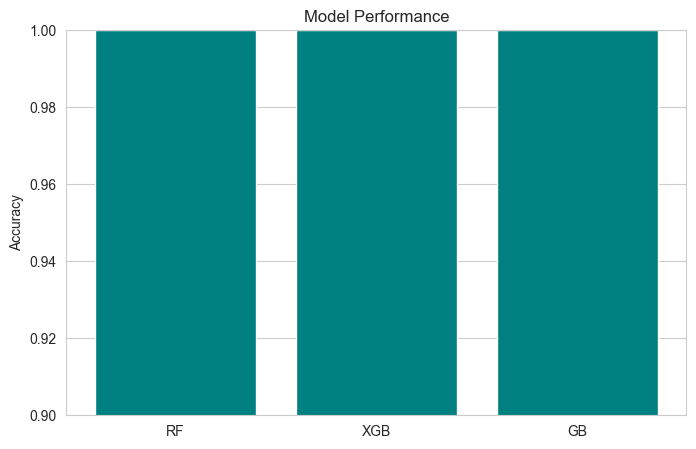

In [60]:
print(f'RF: {rf_acc:.4f}, XGB: {xg_acc:.4f}, GB: {gb_acc:.4f}')
plt.figure(figsize=(8,5))
plt.bar(['RF','XGB','GB'], [rf_acc,xg_acc,gb_acc], color='teal')
plt.ylim(0.9,1.0)
plt.ylabel('Accuracy')
plt.title('Model Performance')
plt.show()

In [61]:
best = max([(rf_acc,'RF',rf),(xg_acc,'XGB',xg),(gb_acc,'GB',gb)])
print(f'Best: {best[1]} - {best[0]:.4f}')

joblib.dump(best[2],'models/accident_severity_model.pkl')
joblib.dump(sc,'models/feature_scaler.pkl')
joblib.dump(le,'models/label_encoders.pkl')
joblib.dump(feats,'models/feature_names.pkl')
joblib.dump({'model_type':best[1],'accuracy':best[0]},'models/model_metadata.pkl')
print('saved')

Best: XGB - 1.0000
saved


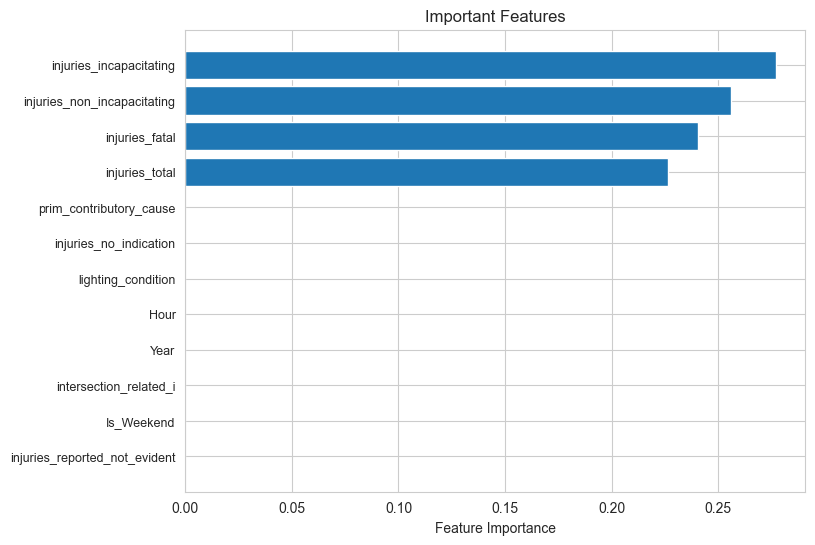

In [62]:
top_n = 12
importance = best[2].feature_importances_
top_idx = np.argsort(importance)[-top_n:]
plt.figure(figsize=(8,6))
plt.barh(range(top_n), importance[top_idx])
plt.yticks(range(top_n), [feats[i] for i in top_idx], fontsize=9)
plt.xlabel('Feature Importance')
plt.title('Important Features')
plt.show()

In [63]:
y_pred = best[2].predict(X_test)
print('\nConfusion Matrix:')
print(confusion_matrix(y_test, y_pred))
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=['No Injury','Non-Incap','Incap','Fatal']))


Confusion Matrix:
[[30954     0     0     0]
 [    0  6304     0     0]
 [    0     0  1313     0]
 [    0     0     0    70]]

Classification Report:
              precision    recall  f1-score   support

   No Injury       1.00      1.00      1.00     30954
   Non-Incap       1.00      1.00      1.00      6304
       Incap       1.00      1.00      1.00      1313
       Fatal       1.00      1.00      1.00        70

    accuracy                           1.00     38641
   macro avg       1.00      1.00      1.00     38641
weighted avg       1.00      1.00      1.00     38641



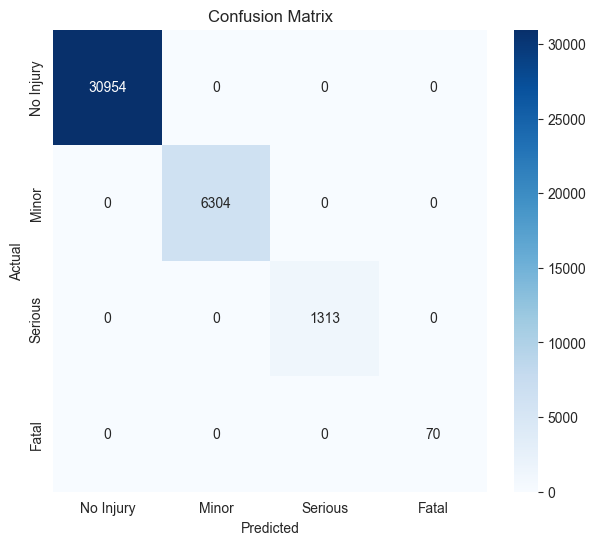

In [64]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Injury','Minor','Serious','Fatal'],
            yticklabels=['No Injury','Minor','Serious','Fatal'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()